# Import Modules

In [3]:
%matplotlib inline
#%matplotlib notebook

#Basic stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# ML models
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer

# Regression metrics
from sklearn.metrics import explained_variance_score, median_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Chemistry-related
# import molvs
#from rdkit.Chem import SaltRemover
#from rdkit.Chem.rdmolops import RDKFingerprint
#from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from mordred import Calculator, descriptors

# Initialize tqdm progress bar
from tqdm import tqdm, tnrange, tqdm_notebook
from tqdm.auto import tqdm
tqdm.pandas(tqdm_notebook)

# This is to force a better visuialization of molecules in Pandas
PandasTools.ChangeMoleculeRendering(renderer='String')

In [2]:
%reload_ext autoreload
%autoreload 2
# The averaged random forest model
from MTase.AverageRandomForests import AverageRF
from MTase.utils import train_test_split_data

# Data

## Experiment

In [4]:
active = pd.read_pickle("./data/active_df.pkl.bz2")
inactive = pd.read_pickle("./data/inactive_df.pkl.bz2")
inconclusive = pd.read_pickle("./data/inconclusive_df.pkl.bz2")

# Add active bit for classification tasks
active['ActiveBit']   = True
inactive['ActiveBit'] = False

columns = ['PUBCHEM_SID', 'mol', 'Log IC50', 'IC50', 'ActiveBit']

data = active.append(inactive, ignore_index=True).filter(columns, axis=1)

C:\Users\gmseabra\Miniconda3\envs\unc\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Descriptors

In [ ]:
#The Mordred Descriptor Calculator
# mordred_calc = Calculator(descriptors, ignore_3D=True)

# Calculates the Mordred descriptors for all molecules in the DataFrame
# df_mordred = mordred_calc.pandas(data['mol'])
#df_mordred.to_pickle("./data/df_mordred_raw.pkl.bz2")

In [5]:
df_mordred = pd.read_pickle("./data/df_mordred_raw.pkl.bz2")

In [7]:
df_mordred.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,27.909982,20.202848,0,0,47.870926,2.398509,4.797018,47.870926,1.259761,4.515267,...,10.303907,74.058154,528.272318,6.772722,7267,57,178.0,202.0,14.111111,8.972222
1,13.601438,10.852910,0,0,21.735859,2.479401,4.958802,21.735859,1.278580,3.792207,...,9.976692,50.493909,229.037508,9.543229,472,29,94.0,113.0,5.527778,3.611111
2,23.408122,20.241546,0,0,39.182909,2.564373,4.959054,39.182909,1.306097,4.339714,...,10.362715,82.937982,422.093643,8.793618,2267,48,160.0,193.0,9.722222,6.666667
3,12.215734,10.986552,0,0,19.977508,2.483201,4.966402,19.977508,1.248594,3.703323,...,9.907231,49.015363,280.968755,11.707031,389,29,84.0,102.0,6.777778,3.583333
4,11.399237,10.337988,0,0,19.227391,2.471973,4.943946,19.227391,1.281826,3.639920,...,9.829464,47.643536,266.953105,12.712053,322,27,78.0,95.0,5.916667,3.416667


In [8]:
# Remove missing values
tqdm.pandas(desc='Mapping NaNs...')
missing = df_mordred.progress_applymap(lambda x: isinstance(x, (int, float)))
df_mordred = df_mordred.where(missing, 0)

In [11]:
df_mordred.to_pickle("./data/df_mordred_clean.pkl.bz2")

### Normalization 

In [12]:
from sklearn import preprocessing

In [13]:
mordred_scaler = preprocessing.StandardScaler().fit(df_mordred)

C:\Users\gmseabra\Miniconda3\envs\unc\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [21]:
df_mordred.describe()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
count,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,...,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000,50829.000000
mean,19.616316,15.787331,0.085306,0.210864,32.538984,2.428803,4.802768,32.538984,1.281340,4.130582,...,10.046572,68.885570,362.812165,8.151716,1910.896831,38.632513,131.031576,152.928132,8.429665,5.627773
std,4.646033,3.173355,0.341685,0.529636,7.717275,0.086948,0.154982,7.717275,0.039913,0.236880,...,0.349946,10.577973,82.754219,1.123317,1672.792688,11.719569,32.483753,40.061378,2.202748,1.282468
min,3.754314,4.057055,0.000000,0.000000,6.155367,1.847759,3.695518,6.155367,0.923081,2.595100,...,6.900731,29.439488,84.043596,4.571401,26.000000,2.000000,20.000000,18.000000,1.944444,1.416667
25%,16.441795,13.640605,0.000000,0.000000,27.316747,2.371983,4.702014,27.316747,1.258032,3.985051,...,9.840601,61.093332,306.173213,7.398939,1038.000000,31.000000,108.000000,126.000000,6.916667,4.750000
50%,19.396191,15.661715,0.000000,0.000000,32.227498,2.429982,4.802461,32.227498,1.284662,4.145196,...,10.076137,69.465570,359.153286,8.002996,1638.000000,38.000000,130.000000,151.000000,8.277778,5.569444
75%,22.534606,17.728813,0.000000,0.000000,37.349903,2.483429,4.905579,37.349903,1.308756,4.293727,...,10.281684,76.551351,415.153206,8.731729,2461.000000,46.000000,152.000000,178.000000,9.729167,6.416667
max,74.741362,56.922187,4.000000,7.000000,122.757050,3.071646,5.722494,122.757050,1.425348,5.484449,...,12.049694,156.297835,1421.748941,18.768044,90016.000000,190.000000,490.000000,616.000000,40.666667,22.750000


In [24]:
df_mordred_scaled = pd.DataFrame(mordred_scaler.transform(df_mordred), columns=df_mordred.columns)

C:\Users\gmseabra\Miniconda3\envs\unc\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype bool, int64, float64, object were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [25]:
df_mordred_scaled.describe()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
count,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,...,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04,5.082900e+04
mean,4.199316e-16,-9.198236e-17,2.879691e-17,4.221683e-17,-6.413603e-16,3.560192e-15,-4.241253e-15,-6.384247e-16,2.074286e-15,4.545997e-16,...,1.506945e-16,-4.864720e-17,-4.070709e-16,1.999009e-17,-5.032469e-17,1.020473e-16,1.957071e-18,2.066108e-16,1.200104e-15,-3.466812e-17
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,...,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00
min,-3.414129e+00,-3.696527e+00,-2.496638e-01,-3.981340e-01,-3.418807e+00,-6.682683e+00,-7.144462e+00,-3.418807e+00,-8.976091e+00,-6.482175e+00,...,-8.989583e+00,-3.729114e+00,-3.368666e+00,-3.187301e+00,-1.126808e+00,-3.125787e+00,-3.418099e+00,-3.368068e+00,-2.944179e+00,-3.283628e+00
25%,-6.832822e-01,-6.764914e-01,-2.496638e-01,-3.981340e-01,-6.767011e-01,-6.534896e-01,-6.501104e-01,-6.767011e-01,-5.839849e-01,-6.143692e-01,...,-5.885833e-01,-7.366548e-01,-6.844305e-01,-6.701442e-01,-5.218252e-01,-6.512687e-01,-7.090253e-01,-6.721785e-01,-6.868752e-01,-6.844470e-01
50%,-4.737948e-02,-3.958475e-02,-2.496638e-01,-3.981340e-01,-4.036253e-02,1.356767e-02,-1.983794e-03,-4.036253e-02,8.322288e-02,6.169339e-02,...,8.448787e-02,5.483148e-02,-4.421423e-02,-1.323950e-01,-1.631401e-01,-5.397120e-02,-3.175700e-02,-4.812991e-02,-6.895409e-02,-4.548166e-02
75%,6.281313e-01,6.118137e-01,-2.496638e-01,-3.981340e-01,6.234022e-01,6.282715e-01,6.633777e-01,6.234022e-01,6.869092e-01,6.887310e-01,...,6.718601e-01,7.246999e-01,6.324941e-01,5.163440e-01,3.288564e-01,6.286545e-01,6.455113e-01,6.258426e-01,5.899516e-01,6.151435e-01
max,1.186509e+01,1.296270e+01,1.145713e+01,1.281863e+01,1.169052e+01,7.393460e+00,5.934473e+00,1.169052e+01,3.608094e+00,5.715470e+00,...,5.724140e+00,8.263693e+00,1.279629e+01,9.450964e+00,5.266999e+01,1.291592e+01,1.105082e+01,1.155917e+01,1.463505e+01,1.335113e+01


# Regression

In [96]:
def test_regression_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    evs = explained_variance_score(y_test,y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    med_ae = median_absolute_error(y_test, y_pred)
    r2sc = r2_score(y_test, y_pred)

    # Regression stats
    print(f"\tExplained Variance Score = {evs:.2f}")
    print(f"\tMean Absolute Error      = {mae:.2f}")
    print(f"\tMean SQUARED error       = {mse:.2f}")
    print(f"\tMEDIAN ansolute error    = {med_ae:.2f}")
    print(f"\tR^2 Score                = {r2sc:.2f}")

    return y_pred, {"Explained Variance":evs, "MAE":mae, "MSE":mse, "Med_AE":med_ae,"R2":r2sc}

In [44]:
# Regression data contains only the actives
actives_X = df_mordred_scaled[:829]
actives_y = active['Log IC50']
act_X_train, act_X_test, act_y_train, act_y_test = train_test_split(actives_X, actives_y, test_size=0.10, shuffle=True)

print("X_train:", len(act_X_train), "\t\ty_train:",len(act_y_train))
print("X_test: ", len(act_X_test), "\t\ty_test: ",len(act_y_test))
print("-"*36)
print("TOTAL:",len(act_X_train) + len(act_X_test))

X_train: 746 		y_train: 746
X_test:  83 		y_test:  83
------------------------------------
TOTAL: 829


In [136]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor, BayesianRidge, ARDRegression
from sklearn.svm import SVR

# Define different models to try
reg_df = pd.DataFrame(columns=["Estimator","Explained Variance","MAE","MSE","Med_AE","R2"])
pred_df = pd.DataFrame({'LogIC50':act_y_test.values})
models = []
# Base Estimators
models.append(("Grad Boost", GradientBoostingRegressor(n_estimators=250, max_features='sqrt')))
models.append(("SGD", SGDRegressor(max_iter=1000, tol=1e-3)))
models.append(("Bayesian Ridge", BayesianRidge(n_iter=1000, normalize=True)))
models.append(("ARDR", ARDRegression(n_iter=2000)))
models.append(("SVR", SVR(kernel="rbf",gamma="scale", epsilon=0.05)))
models.append(("RF", RandomForestRegressor(bootstrap=True, criterion='mse',
                                  max_features="sqrt", n_estimators=200, n_jobs=4, warm_start=False, 
                                  random_state=42)))

for estimator, model in models:
    print("\nEstimator: ", estimator)
    pred, results = test_regression_model(model, act_X_train, act_y_train, act_X_test, act_y_test)
    results["Estimator"] = estimator
    pred_df[estimator] = pred
    reg_df = reg_df.append(results, ignore_index=True)


Estimator:  Grad Boost
	Explained Variance Score = 0.28
	Mean Absolute Error      = 0.18
	Mean SQUARED error       = 0.06
	MEDIAN ansolute error    = 0.14
	R^2 Score                = 0.28

Estimator:  SGD
	Explained Variance Score = -3744011024838054824116224.00
	Mean Absolute Error      = 389808932740.31
	Mean SQUARED error       = 301934105255945751756800.00
	MEDIAN ansolute error    = 317910426428.69
	R^2 Score                = -3861371051391308353503232.00

Estimator:  Bayesian Ridge
	Explained Variance Score = -0.02
	Mean Absolute Error      = 0.21
	Mean SQUARED error       = 0.08
	MEDIAN ansolute error    = 0.18
	R^2 Score                = -0.02

Estimator:  ARDR
	Explained Variance Score = -0.31
	Mean Absolute Error      = 0.23
	Mean SQUARED error       = 0.10
	MEDIAN ansolute error    = 0.15
	R^2 Score                = -0.33

Estimator:  SVR
	Explained Variance Score = 0.28
	Mean Absolute Error      = 0.17
	Mean SQUARED error       = 0.06
	MEDIAN ansolute error    = 0.14
	R^2 

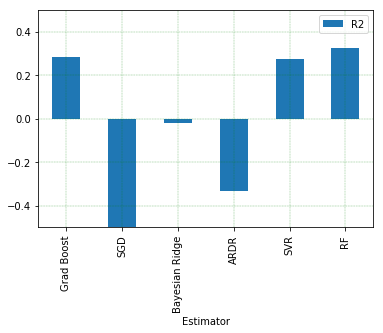

In [137]:
reg_df.plot.bar(x='Estimator', y='R2')
plt.ylim([-0.5,0.5])
plt.grid(color='g', linestyle='-.', linewidth=0.25)

In [138]:
pred_df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,LogIC50,Grad Boost,SGD,Bayesian Ridge,ARDR,SVR,RF
LogIC50,1,0.53,0.16,0.27,0.38,0.53,0.6
Grad Boost,0.53,1,0.052,0.51,0.42,0.81,0.87
SGD,0.16,0.052,1,-0.23,0.33,0.087,0.13
Bayesian Ridge,0.27,0.51,-0.23,1,0.43,0.55,0.49
ARDR,0.38,0.42,0.33,0.43,1,0.51,0.48
SVR,0.53,0.81,0.087,0.55,0.51,1,0.78
RF,0.6,0.87,0.13,0.49,0.48,0.78,1


In [139]:
pred_df.corr().applymap(lambda x: x**2).style.background_gradient(cmap='coolwarm').set_precision(2)

,LogIC50,Grad Boost,SGD,Bayesian Ridge,ARDR,SVR,RF
LogIC50,1,0.28,0.026,0.071,0.15,0.28,0.36
Grad Boost,0.28,1,0.0028,0.26,0.18,0.66,0.76
SGD,0.026,0.0028,1,0.053,0.11,0.0075,0.016
Bayesian Ridge,0.071,0.26,0.053,1,0.19,0.3,0.24
ARDR,0.15,0.18,0.11,0.19,1,0.26,0.23
SVR,0.28,0.66,0.0075,0.3,0.26,1,0.61
RF,0.36,0.76,0.016,0.24,0.23,0.61,1


In [150]:
reg_df[reg_df['Estimator'] == 'SVR']['R2'].values[0]

0.273367030838478

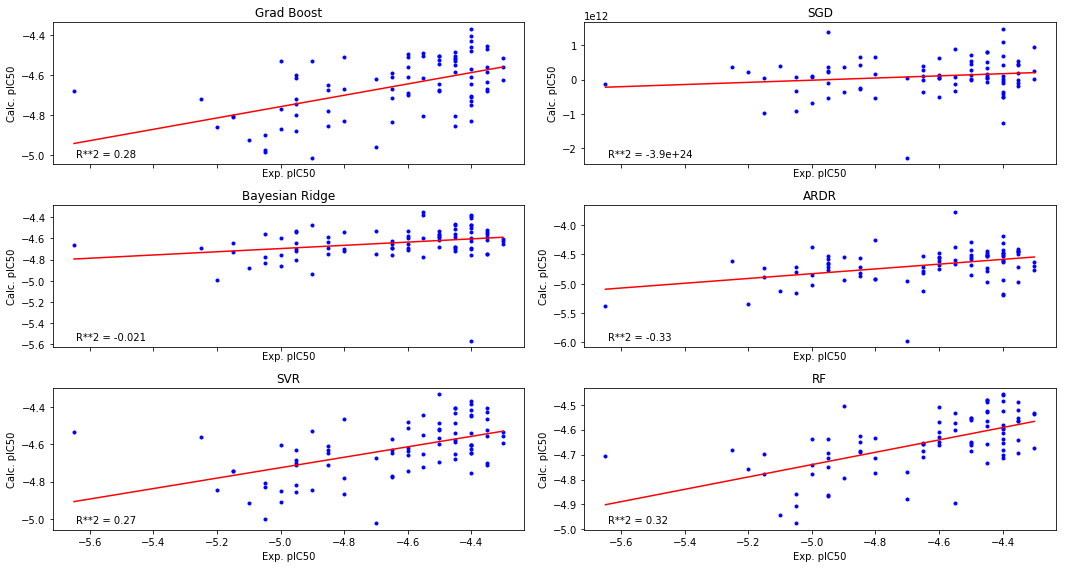

In [153]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,8), sharex=True)
model = 0
for i in range(3):
    for j in range(2):
        name = models[model][0]
        _r2 = reg_df[reg_df['Estimator'] == name]['R2'].values[0]
        text = f"R**2 = {_r2:0.2}"
        fit_fn = np.poly1d(np.polyfit(act_y_test,pred_df[name],1))
        fit_lim = [min(act_y_test),max(act_y_test)]
        ax[i,j].plot(act_y_test,pred_df[name], "b.",fit_lim,fit_fn(fit_lim),"r")
        ax[i,j].set_xlabel("Exp. pIC50")
        ax[i,j].set_ylabel("Calc. pIC50")
        ax[i,j].text(0.05,0.05,text,transform=ax[i,j].transAxes)
        ax[i,j].set_title(name)
        model = model +1
plt.tight_layout()

# Classification

In [154]:
X_data = data.index
y_data = data['ActiveBit'].values
X_train_index, X_test_index, y_train, y_test = train_test_split_data(X_data, y_data, rate_inactives=0.90)

X_train:  7461 	y_train:  7461 	( 746 actives and 6715 inactives)
X_test:   829  	y_test:   829  	( 83 actives and 746 inactives)


In [155]:
X_train_mordred = df_mordred_scaled.iloc[X_train_index]
X_test_mordred  = df_mordred_scaled.iloc[X_test_index]

In [160]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features=0.33,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=4, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [161]:
model.fit(X_train_mordred, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features=0.33,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=4, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [162]:
from MTase.utils import evaluate_classifier_model

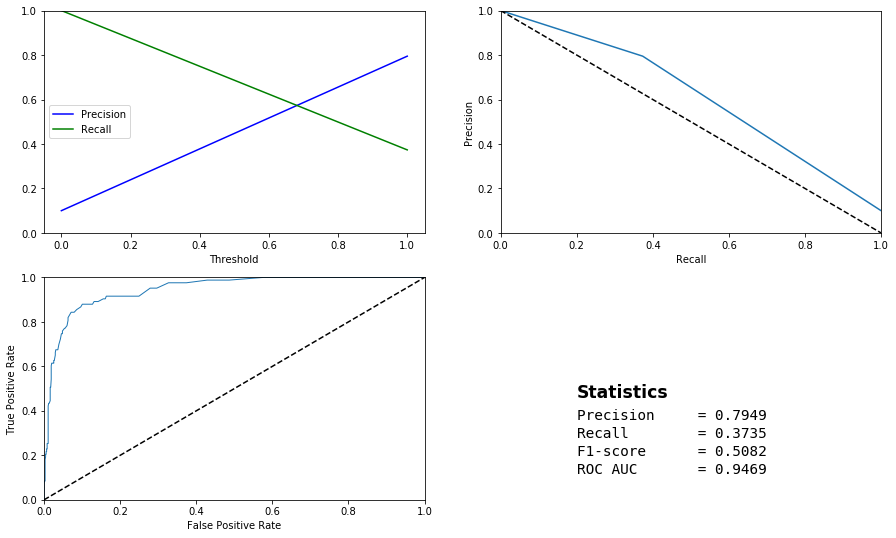

{'Precision': 0.7948717948717948,
 'Recall': 0.37349397590361444,
 'F1_Score': 0.5081967213114753,
 'ROC_AUC': 0.9469055848057107}

In [164]:
evaluate_classifier_model(model,X_test_mordred, y_test)